In [11]:
#!/usr/bin/python
"""
Generate a 3D box in real space with some power spectrum. (Phil Bull, May 2012)
"""

import numpy as np
import scipy.integrate
import scipy.fftpack as fft
import pyccl as ccl
import pylab as P
P.rcParams["figure.figsize"]=(15, 10)
#cosmo = ccl.Cosmology(Omega_c=0.315, Omega_b=0.049, h=0.67, n_s=0.96, sigma8=0.83)
#ccl.linear_matter_power(cosmo, k, 1/(1+z))

# Define default cosmology
DEFAULT_COSMOLOGY = ccl.Cosmology(Omega_c=0.315, Omega_b=0.049, h=0.67, n_s=0.96, sigma8=0.83)


class CosmoBox(object):

    def __init__(self, cosmo=DEFAULT_COSMOLOGY, scale=1e3, nsamp=32):
        """Initialise a box containing a matter distribution with a given power 
           spectrum. 'scale' gives the side length (in Mpc) of the cubic box, 
           and 'nsamp' gives the no. of grid points per dimension."""
        
        self.cosmo = cosmo # Cosmological parameters, required by Cosmolopy fns.
        
        # Define grid coordinates along one dimension
        self.x = np.linspace(-scale, scale, nsamp) # in Mpc
        self.N = self.x.size # Grid points
        self.L = self.x[-1] - self.x[0] # Linear size of box
        
        # Conversion factor for FFT of power spectrum
        # For an example, see in liteMap.py:fillWithGaussianRandomField() in 
        # Flipper, by Sudeep Das. http://www.astro.princeton.edu/~act/flipper
        self.boxfactor = (self.N**6.) / self.L**3.
        
        # Fourier mode array
        self.set_fft_sample_spacing() # 3D array, arranged in correct order
        
        # Min./max. k modes in 3D (excl. zero mode)
        self.kmin = 2.*np.pi/self.L
        self.kmax = 2.*np.pi*np.sqrt(3.)*self.N/self.L
        
        # Create a realisation of density/velocity perturbations in the box
        self.realise_density()
        self.realise_velocity()
        self.realise_potential()


    def set_fft_sample_spacing(self):
        """Calculate the sample spacing in Fourier space, given some symmetric 3D 
           box in real space, with 1D grid point coordinates 'x'."""
        self.kx = np.zeros((self.N,self.N,self.N))
        self.ky = np.zeros((self.N,self.N,self.N))
        self.kz = np.zeros((self.N,self.N,self.N))
        NN = ( self.N*fft.fftfreq(self.N, 1.) ).astype("i")
        for i in NN:
            self.kx[i,:,:] = i
            self.ky[:,i,:] = i
            self.kz[:,:,i] = i
        fac = (2.*np.pi/self.L)
        self.k = np.sqrt(self.kx**2. + self.ky**2. + self.kz**2.) * fac

    def realise_density(self):
        """
        Create realisation of the matter power spectrum by randomly sampling 
        from Gaussian distributions of variance P(k) for each k mode.
        """
        # Calculate matter power spectrum
        # FIXME: To avoid errors from Cosmolopy, should replace k=0 with NaN
        k = self.k.flatten() # FIXME: Lots of dup. values. Be more efficient.
        
        #################
        
        #pk = cp.perturbation.power_spectrum(k, z=0.0, **self.cosmo)
        pk = ccl.linear_matter_power(self.cosmo, k, 1)
        
        ##################
        
        pk = np.reshape(pk, np.shape(self.k))
        pk = np.nan_to_num(pk) # Remove NaN at k=0 (and any others...)
        
        # Normalise the power spectrum properly (factor of volume, and norm. 
        # factor of 3D DFT)
        pk *= self.boxfactor
        
        # Generate Gaussian random field with given power spectrum
        re = np.random.normal(0.0, 1.0, np.shape(self.k))
        im = np.random.normal(0.0, 1.0, np.shape(self.k))
        self.delta_k = ( re + 1j*im ) * np.sqrt(pk)
        
        # Transform to real space. Here, we are discarding the imaginary part 
        # of the inverse FT! But we can recover the correct (statistical) 
        # result by multiplying by a factor of sqrt(2). Also, there is a factor 
        # of N^3 which seems to appear by a convention in the Discrete FT.
        self.delta_x = fft.ifftn(self.delta_k).real
        
        # Finally, get the Fourier transform on the real field back
        self.delta_k = fft.fftn(self.delta_x)
        
    
    def realise_velocity(self):
        """
        Realise the (unscaled) velocity field in Fourier space. See 
        Dodelson Eq. 9.18 for an expression; we factor out the 
        time-dependent quantities here. They can be added at a later stage.
        """
        # If the FFT has an even number of samples, the most negative frequency 
        # mode must have the same value as the most positive frequency mode. 
        # However, when multiplying by 'i', allowing this mode to have a 
        # non-zero real part makes it impossible to satisfy the reality 
        # conditions. As such, we can set the whole mode to be zero, make sure 
        # that it's pure imaginary, or use an odd number of samples. Different 
        # ways of dealing with this could change the answer!
        if self.N % 2 == 0: # Even no. samples
            # Set highest (negative) freq. to zero
            mx = np.where(self.kx == np.min(self.kx))
            my = np.where(self.ky == np.min(self.ky))
            mz = np.where(self.kz == np.min(self.kz))
            self.kx[mx] = 0.0; self.ky[my] = 0.0; self.kz[mz] = 0.0
        
        # Get squared k-vector in k-space (and factor in scaling from kx, ky, kz)
        k2 = self.k**2.
        
        # Calculate components of A (the unscaled velocity)
        Ax = 1j * self.delta_k * self.kx * (2.*np.pi/self.L) / k2
        Ay = 1j * self.delta_k * self.ky * (2.*np.pi/self.L) / k2
        Az = 1j * self.delta_k * self.kz * (2.*np.pi/self.L) / k2
        Ax = np.nan_to_num(Ax)
        Ay = np.nan_to_num(Ay)
        Az = np.nan_to_num(Az)
        
        # v(k) = i [f(a) H(a) a] delta_k vec{k} / k^2
        self.velocity_k = (Ax, Ay, Az)
    
    def realise_potential(self):
        """
        Realise the (unscaled) potential in Fourier space. Time-dependent 
        quantities have been factored out, and can be added in at a later stage.
        """
        # Phi = 3/2 (Omega_m H_0^2) (D(a) / a) delta(k) / k^2
        # (Overall scaling factor due to FT should already be included in delta_k?)
        # fac = (3./2.) * self.cosmo['omega_M_0'] * (100.*self.cosmo['h'])**2.
        fac = (3./2.) * 0.315 * (100.* 0.67)**2.
        
        self.phi_k = self.delta_k / self.k**2.
        self.phi_k[0,0,0] = 0.
        #self.phi_x = fft.ifftn(self.phi_k).real # FIXME: Is this correct?

    
    ############################################################################
    # Output quantities related to the realisation
    ############################################################################
    
    def window(self, k, R):
        """
        Fourier transform of tophat window function, used to calculate 
        sigmaR etc. See "Cosmology", S. Weinberg, Eq.8.1.46.
        """
        x = k*R
        f = (3. / x**3.) * ( np.sin(x) - x*np.cos(x) )
        return f**2.
    
    def window1(self, k, R):
        """
        Fourier transform of tophat window function, used to calculate 
        sigmaR etc. See "Cosmology", S. Weinberg, Eq.8.1.46.
        """
        x = k*R
        f = (3. / x**3.) * ( np.sin(x) - x*np.cos(x) )
        return f
    
    def smooth_field(self, field_k, R):
        """
        Smooth a given (Fourier-space) field using a tophat filter with scale 
        R h^-1 Mpc, and then return real-space copy of smoothed field.
        """
        dk = field_k #np.reshape(field_k, np.shape(self.k))
        dk = dk * self.window1(self.k, R/self.cosmo['h'])
        dk = np.nan_to_num(dk)
        dx = fft.ifftn(dk)
        return dx
    
    def lognormal(self, delta_x):
        """
        Return a log-normal transform of the input field (see Eq. 7 of Alonso 
        et al., arXiv:1405.1751).
        """
        # Gaussian variance (measured empirically from input box)
        sigma_G = np.std(delta_x)
        
        # Log-normal transformation
        delta_ln = np.exp(delta_x - 0.5*sigma_G**2.) - 1.
        return delta_ln
        
    
    def sigmaR(self, R):
        """
        Get variance of matter perturbations, smoothed with a tophat filter 
        of radius R h^-1 Mpc.
        """
        # Need binned power spectrum, with k flat, monotonic for integration.
        k, pk, stddev = self.binned_power_spectrum()
        
        # Only use non-NaN values
        #good_idxs = -np.isnan(pk)
        good_idxs = ~np.isnan(pk)
        pk = pk[good_idxs]
        k = k[good_idxs]
        
        # Discretely-sampled integrand, y
        #y = k**2. * pk * self.window(k, R/self.cosmo['h'])
        y = k**2. * pk * self.window(k, R/0.67)
        I = scipy.integrate.simps(y, k)
        
        # Return sigma_R (note factor of 4pi / (2pi)^3 from integration)
        return np.sqrt( I / (2. * np.pi**2.) )
           
    
    def sigma8(self):
        """
        Get variance of matter perturbations on smoothing scale 
        of 8 h^-1 Mpc.
        """
        return self.sigmaR(8.0)
    
    def binned_power_spectrum(self, nbins=20, delta_k=None):
        """Return a binned power spectrum, calculated from the realisation."""
        if delta_k is None: delta_k = self.delta_k
        pk = delta_k * np.conj(delta_k) # Power spectrum (noisy)
        pk = pk.real / self.boxfactor
        
        # Bin edges/centroids. Logarithmically-distributed bins in k-space.
        # FIXME: Needs to be checked for correctness
        bins = np.logspace(np.log10(self.kmin), np.log10(self.kmax), nbins)
        _bins = [0.0] + list(bins) # Add zero to the beginning
        cent = [0.5*(_bins[j+1] + _bins[j]) for j in range(bins.size)]
        
        # Initialise arrays
        vals = np.zeros(bins.size)
        stddev = np.zeros(bins.size)
        
        # Identify which bin each element of 'pk' should go into
        idxs = np.digitize(self.k.flatten(), bins)
        
        # For each bin, get the average pk value in that bin
        for i in range(bins.size):
            ii = np.where(idxs==i, True, False)
            vals[i] = np.mean(pk.flatten()[ii])
            stddev[i] = np.std(pk.flatten()[ii])
        
        # First value is garbage, so throw it away
        return np.array(cent[1:]), np.array(vals[1:]), np.array(stddev[1:])
    
    def theoretical_power_spectrum(self):
        """
        Calculate the theoretical power spectrum for the given cosmological 
        parameters, using Cosmolopy. Does not depend on the realisation.
        """
        k = np.logspace(-3.5, 1., 1e3)
        
        #############
        
        #pk = cp.perturbation.power_spectrum(k, z=0.0, **self.cosmo)
        pk = ccl.linear_matter_power(self.cosmo, k, 1)
        
        #############
        
        return k, pk
        
    
    
    ############################################################################
    # Tests for consistency and accuracy
    ############################################################################
    
    def test_sampling_error(self):
        """P(k) is sampled within some finite window in the interval 
           [kmin, kmax], where kmin=2pi/L and kmax=2pi*sqrt(3)*(N/2)*(1/L) 
           (for 3D FT). The lack of sampling in some regions of k-space means 
           that sigma8 can't be perfectly reconstructed (see U-L. Pen, 
           arXiv:astro-ph/9709261 for a discussion).
           This function calculates sigma8 from the realised box, and compares 
           this with the theoretical calculation for sigma8 over a large 
           k-window, and over a k-window of the same size as for the box.
        """
        
        # Calc. sigma8 from the realisation
        s8_real = self.sigma8()
        
        # Calc. theoretical sigma8 in same k-window as realisation
        _k = np.linspace(self.kmin, self.kmax, 5e3)
        
        ############
        
        #_pk = cp.perturbation.power_spectrum(_k, z=0.0, **self.cosmo)
        _pk = ccl.linear_matter_power(self.cosmo, _k, 1)
        
        ############
        
        _y = _k**2. * _pk * self.window(_k, 8.0/self.cosmo['h'])
        _y = np.nan_to_num(_y)
        s8_th_win = np.sqrt( scipy.integrate.simps(_y, _k) / (2. * np.pi**2.) )
        
        # Calc. full sigma8 (in window that is wide enough)
        _k2 = np.logspace(-5, 2, 5e4)
        
        ############
        
        #_pk2 = cp.perturbation.power_spectrum(_k2, z=0.0, **self.cosmo)
        _pk2 = ccl.linear_matter_power(self.cosmo, _k2, 1)

        ############
        
        _y2 = _k2**2. * _pk2 * self.window(_k2, 8.0/self.cosmo['h'])
        _y2 = np.nan_to_num(_y2)
        s8_th_full = np.sqrt( scipy.integrate.simps(_y2, _k2) / (2. * np.pi**2.) )
        
        # Calculate sigma8 in real space
        dk = np.reshape(self.delta_k, np.shape(self.k))
        dk = dk * self.window1(self.k, 8.0/self.cosmo['h'])
        dk = np.nan_to_num(dk)
        dx = fft.ifftn(dk)
        s8_realspace = np.std(dx)
        
        # sigma20
        dk = np.reshape(self.delta_k, np.shape(self.k))
        dk = dk * self.window1(self.k, 20.0/self.cosmo['h'])
        dk = np.nan_to_num(dk)
        dx = fft.ifftn(dk)
        s20_realspace = np.std(dx)
        
        s20_real = self.sigmaR(20.)
        
        # Print report
        print("")
        print("sigma8 (real.): \t", s8_real)
        print("sigma8 (th.win.):\t", s8_th_win)
        print("sigma8 (th.full):\t", s8_th_full)
        print("sigma8 (realsp.):\t", s8_realspace)
        print("ratio =", 1. / (s8_real / s8_realspace))
        print("")
        print("sigma20 (real.): \t", s20_real)
        print("sigma20 (realsp.):\t", s20_realspace)
        print("ratio =", 1. / (s20_real / s20_realspace))
        print("var(delta) =", np.std(self.delta_x))

    def test_parseval(self):
        """
        Ensure that Parseval's theorem is satisfied for delta_x and delta_k, 
        i.e. <delta_x^2> = Sum_k[P(k)]. Important consistency check for FT;
        should return unity if everything is OK.
        """
        s1 = np.sum(self.delta_x**2.) * self.N**3. # Factor of N^3 missing due to averaging
        s2 = np.sum(self.delta_k*np.conj(self.delta_k)).real
        print("Parseval test:", s1/s2, "(should be 1.0)")

/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide
/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide
/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in true_divide
/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/astro/kennedy/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1


sigma8 (real.): 	 0.8259240633606375
sigma8 (th.win.):	 0.8289407769580364
sigma8 (th.full):	 0.8297692302425805
sigma8 (realsp.):	 0.7997005061515196
ratio = 0.9682494331229244

sigma20 (real.): 	 0.3853334874921466
sigma20 (realsp.):	 0.3880124397187271
ratio = 1.0069522953844887
var(delta) = 1.1144062304555287
Parseval test: 1.0000000000000007 (should be 1.0)


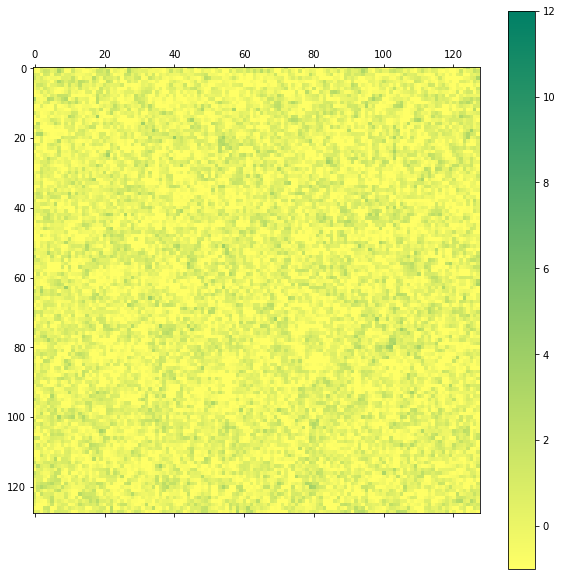

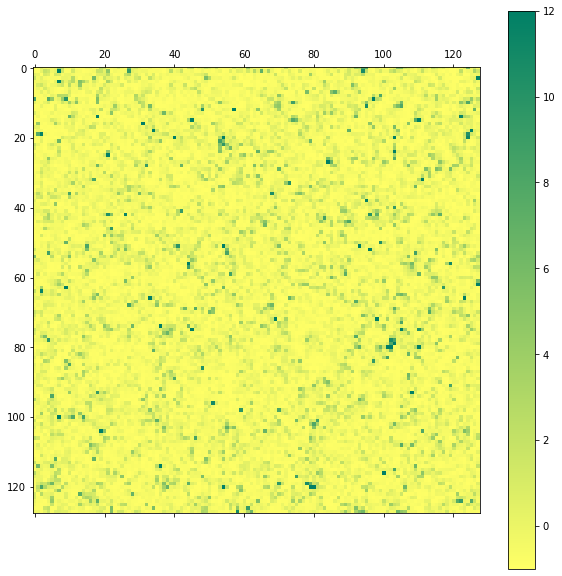

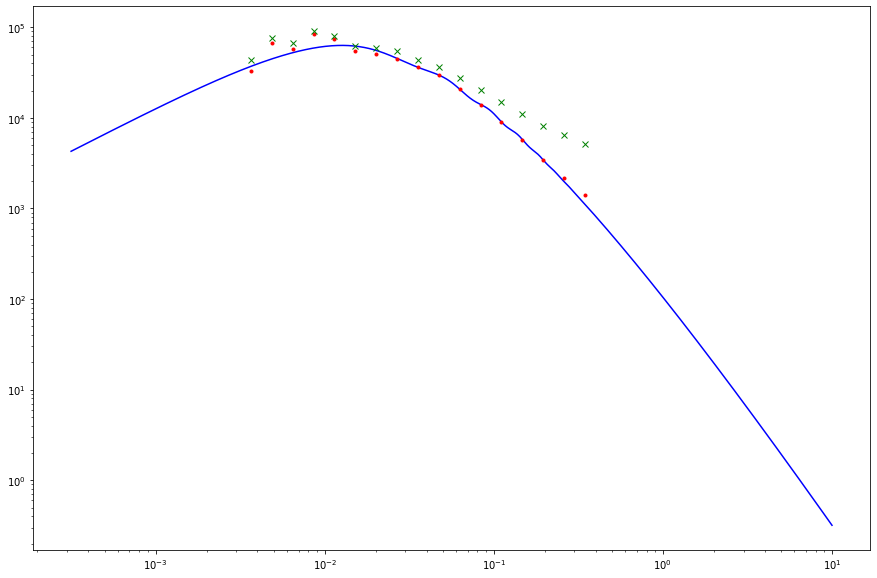

In [12]:
# Gaussian box
box = CosmoBox(scale=1e3, nsamp=128)
re_k, re_pk, re_stddev = box.binned_power_spectrum()
th_k, th_pk = box.theoretical_power_spectrum()

P.matshow(box.delta_x[0], vmin=-1., vmax=12., cmap='summer_r')
P.colorbar()

# Log-normal box
delta_ln = box.lognormal(box.delta_x)
lnre_k, lnre_pk, lnre_stddev \
    = box.binned_power_spectrum(delta_k=fft.fftn(delta_ln))

P.matshow(delta_ln[0], vmin=-1., vmax=12., cmap='summer_r')
P.colorbar()


# Tests
box.test_sampling_error()
box.test_parseval()


# Plot some stuff
fig = P.figure()
P.plot(th_k, th_pk, 'b-')
#P.errorbar(re_k, re_pk, yerr=re_stddev, fmt=".", color='r')
P.plot(re_k, re_pk, 'r.')
P.plot(lnre_k, lnre_pk, 'gx')
P.xscale('log')
P.yscale('log')

"""
P.subplot(212)

def dx(R):
    dk = np.reshape(box.delta_k, np.shape(box.k))
    dk = dk * box.window1(box.k, R/box.cosmo['h'])
    dk = np.nan_to_num(dk)
    dx = fft.ifftn(dk)
    return dx

dx2 = dx(8.0)
dx3 = dx(100.0)

P.hist(dx2.flatten(), bins=100, alpha=0.2)
P.hist(dx3.flatten(), bins=100, alpha=0.2)
"""
P.show()